# The ElasticNet interpretations (for the most abundant cell types)

## Outline

The **MLAging Cell-type** workflow consists of four sections:

I. Data Preprocessing in Seurat ```preprocessing.R```

II. ElasticNet Tuning (hyperparameter selection for  with ```GridSearchCV```): 

1. [Data Preparation](#1.-prep)
2. [Cell Types](#2.-celltypes)
    - [Neuron](#3.-neuron)
    - [Oligodendrycte](#4.-Oligo)
    - [Astrocyte](#5.-astro)
    - [Microglia](#6.-micro)

III. Final Models Over 10 Random States

IV. Results and Intepretations -- **this notebook**:

## 1. Thorough evaluation of the best model<a name="5.-eval"></a>
### a) Normalized cofusion matrix<a name="6.-cm"></a>

In [1]:
import sys
import pandas as pd
import numpy as np
import os

data_type = 'float32'

import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import tqdm
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from operator import itemgetter

from sklearn.metrics import precision_recall_curve, auc

In [2]:
file = open('../results/cell_type_best/Neuron_eln_model_test_models.save', 'rb')
final_models = pickle.load(file)
file.close()

file = open('../results/cell_type_best/Neuron_eln_model_test_sets.save', 'rb')
final_data = pickle.load(file)
file.close()

In [3]:
X = final_data[0][0]

In [4]:
y_tests = []
y_tests_pred = []
y_tests_prob = []
coefs_list = []

for i in range(len(final_data)):
    
    X_test, y_test = final_data[i]
    clf = final_models[i]
    
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test)
    
    coefs = clf.coef_
    
    y_tests.append(y_test)
    y_tests_pred.append(y_test_pred)
    y_tests_prob.append(y_test_prob)
    coefs_list.append(coefs)

In [5]:
plt.figure(figsize = (9,6))
sns.set(font_scale=1.1, style='ticks')

coefs_list_1 = np.array([a[0] for a in coefs_list])
mean_coefs = np.mean(coefs_list_1,axis=0)
std_coefs = np.std(coefs_list_1,axis=0)

<Figure size 648x432 with 0 Axes>

In [6]:
np.sort(mean_coefs)

array([-1.59795857, -1.58250568, -1.34609505, ...,  0.61422116,
        0.62850457,  0.63299762])

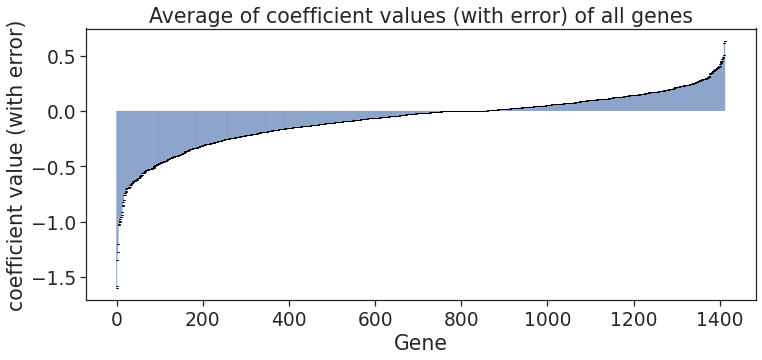

In [7]:
plt.figure(figsize=(12,5))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), np.sort(mean_coefs), yerr=std_coefs, snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')
# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("coefficient value (with error)")
plt.xlabel('Gene')
plt.title("Average of coefficient values (with error) of all genes")
# plt.savefig('../figures/3a_all_coefs.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

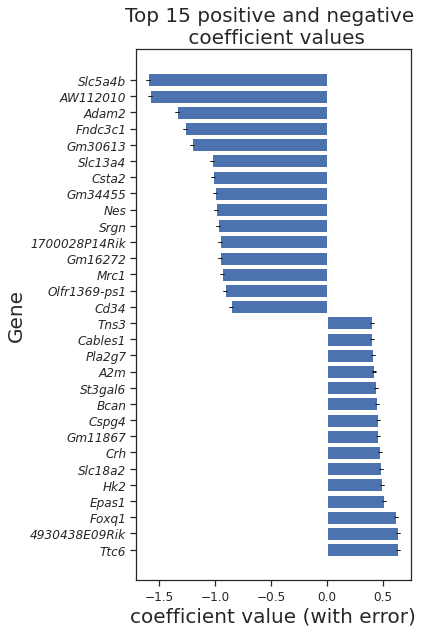

In [8]:
from operator import itemgetter
sns.color_palette()
plt.figure(figsize = (6,9))
sns.set(font_scale=1.1, style='ticks')
# abs_coefs = np.absolute(mean_coefs)
abs_thetas_tuple = [(i,coef) for i,coef in enumerate(mean_coefs)]

results = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)

nr_coefs = 30

top_coefs_result = [(result, X.columns[result[0]]) for result in results][:15]
top_coefs_result = top_coefs_result + [(result, X.columns[result[0]]) for result in results][-15:]# for result in results:
#     print(result, X.columns[result[0]])
top_coefs = [mean_coefs[t[0][0]] for t in top_coefs_result]
top_features = [t[1] for t in top_coefs_result]
std_top_coefs = [std_coefs[t[0][0]] for t in top_coefs_result]

# plt.rcParams.update({'font.size': 14})
plt.barh(np.arange(nr_coefs), top_coefs, yerr=std_top_coefs, capsize=2)
plt.yticks(np.arange(nr_coefs),top_features, style='italic')
plt.xlabel("coefficient value (with error)", fontsize=20)
# plt.xlim(-1.5, 0.5)
plt.title("Top 15 positive and negative \n coefficient values", fontsize=20)
# plt.yticks(rotation=-70)
# plt.grid(axis='x')
plt.ylabel('Gene', fontsize=20)
plt.tight_layout()
# plt.savefig('../figures/3b_top_coefs.PDF')
plt.show()

In [9]:
abs_coefs = np.absolute(mean_coefs)
abs_thetas_tuple = [(i,coef) for i,coef in enumerate(abs_coefs)]
results_abs = sorted(abs_thetas_tuple, key=itemgetter(1), reverse=True)

In [10]:
a = abs_coefs == 0

In [11]:
pd.value_counts(a)

False    1349
True       64
dtype: int64

In [12]:
ranked_list = [X.columns[result[0]] for result in results_abs]

In [13]:
from sklearn.inspection import permutation_importance
# acuumulated perturbation
np.random.seed(42)

ftr_names = ranked_list
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test.copy()

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

shuffling Slc5a4b
shuffled test score: 0.9661 +/- 0.0001
shuffling AW112010
shuffled test score: 0.9653 +/- 0.0001
shuffling Adam2
shuffled test score: 0.9645 +/- 0.0002
shuffling Fndc3c1
shuffled test score: 0.9644 +/- 0.0
shuffling Gm30613
shuffled test score: 0.9632 +/- 0.0001
shuffling Slc13a4
shuffled test score: 0.963 +/- 0.0001
shuffling Csta2
shuffled test score: 0.9618 +/- 0.0001
shuffling Gm34455
shuffled test score: 0.9622 +/- 0.0001
shuffling Nes
shuffled test score: 0.9618 +/- 0.0
shuffling Srgn
shuffled test score: 0.9613 +/- 0.0001
shuffling 1700028P14Rik
shuffled test score: 0.9604 +/- 0.0001
shuffling Gm16272
shuffled test score: 0.9601 +/- 0.0001
shuffling Mrc1
shuffled test score: 0.9597 +/- 0.0
shuffling Olfr1369-ps1
shuffled test score: 0.9596 +/- 0.0001
shuffling Cd34
shuffled test score: 0.9596 +/- 0.0
shuffling Rgs5
shuffled test score: 0.9591 +/- 0.0001
shuffling Pamr1
shuffled test score: 0.9589 +/- 0.0001
shuffling Nek5
shuffled test score: 0.9586 +/- 0.0
shu

shuffled test score: 0.8929 +/- 0.0001
shuffling Ak9
shuffled test score: 0.8914 +/- 0.0001
shuffling Pla2g7
shuffled test score: 0.8916 +/- 0.0001
shuffling Nms
shuffled test score: 0.8909 +/- 0.0001
shuffling Fbxl13
shuffled test score: 0.8896 +/- 0.0001
shuffling Ramp3
shuffled test score: 0.8885 +/- 0.0001
shuffling Cables1
shuffled test score: 0.8891 +/- 0.0001
shuffling Gm34544
shuffled test score: 0.8871 +/- 0.0002
shuffling Tns3
shuffled test score: 0.8872 +/- 0.0001
shuffling Acss1
shuffled test score: 0.887 +/- 0.0
shuffling Lgals9
shuffled test score: 0.8853 +/- 0.0001
shuffling Megf11
shuffled test score: 0.8859 +/- 0.0001
shuffling St8sia2
shuffled test score: 0.8844 +/- 0.0001
shuffling Gm29773
shuffled test score: 0.8831 +/- 0.0002
shuffling Tbx19
shuffled test score: 0.8816 +/- 0.0001
shuffling Gm39653
shuffled test score: 0.8793 +/- 0.0001
shuffling Greb1l
shuffled test score: 0.8798 +/- 0.0001
shuffling 4930445E18Rik
shuffled test score: 0.877 +/- 0.0002
shuffling Rre

shuffled test score: 0.7724 +/- 0.0001
shuffling Mal
shuffled test score: 0.7723 +/- 0.0001
shuffling Mei4
shuffled test score: 0.7744 +/- 0.0001
shuffling Col4a4
shuffled test score: 0.7713 +/- 0.0001
shuffling Eng
shuffled test score: 0.7715 +/- 0.0001
shuffling Sema3c
shuffled test score: 0.7689 +/- 0.0001
shuffling Clic4
shuffled test score: 0.7693 +/- 0.0001
shuffling Itga9
shuffled test score: 0.7683 +/- 0.0001
shuffling Ror1
shuffled test score: 0.7671 +/- 0.0001
shuffling Gm6145
shuffled test score: 0.767 +/- 0.0001
shuffling Cd38
shuffled test score: 0.7661 +/- 0.0001
shuffling Siglech
shuffled test score: 0.7661 +/- 0.0
shuffling Gm29865
shuffled test score: 0.7634 +/- 0.0001
shuffling Thsd4
shuffled test score: 0.765 +/- 0.0001
shuffling Ttc29
shuffled test score: 0.7667 +/- 0.0001
shuffling Unc13b
shuffled test score: 0.768 +/- 0.0001
shuffling Sox5os4
shuffled test score: 0.7671 +/- 0.0001
shuffling Kcnmb2
shuffled test score: 0.7662 +/- 0.0002
shuffling Rbfox1
shuffled te

shuffled test score: 0.7187 +/- 0.0001
shuffling Ajap1
shuffled test score: 0.7199 +/- 0.0001
shuffling March4
shuffled test score: 0.7216 +/- 0.0001
shuffling Gm15398
shuffled test score: 0.722 +/- 0.0001
shuffling Mctp1
shuffled test score: 0.7225 +/- 0.0001
shuffling Col27a1
shuffled test score: 0.7218 +/- 0.0001
shuffling 4930555F03Rik
shuffled test score: 0.7214 +/- 0.0002
shuffling Lix1
shuffled test score: 0.722 +/- 0.0001
shuffling Ociad2
shuffled test score: 0.7204 +/- 0.0002
shuffling Dpyd
shuffled test score: 0.7204 +/- 0.0001
shuffling Fli1
shuffled test score: 0.7203 +/- 0.0
shuffling Zic1
shuffled test score: 0.7191 +/- 0.0001
shuffling Met
shuffled test score: 0.7175 +/- 0.0001
shuffling 9330185C12Rik
shuffled test score: 0.7193 +/- 0.0001
shuffling Nrp2
shuffled test score: 0.7207 +/- 0.0001
shuffling Tgfbr1
shuffled test score: 0.7205 +/- 0.0
shuffling Grm8
shuffled test score: 0.7205 +/- 0.0001
shuffling Cntnap4
shuffled test score: 0.721 +/- 0.0001
shuffling Neto1
sh

shuffled test score: 0.6864 +/- 0.0
shuffling Tafa1
shuffled test score: 0.6864 +/- 0.0001
shuffling Armc2
shuffled test score: 0.6877 +/- 0.0001
shuffling Irf8
shuffled test score: 0.6879 +/- 0.0
shuffling Pth2r
shuffled test score: 0.6863 +/- 0.0001
shuffling Itpkb
shuffled test score: 0.6866 +/- 0.0001
shuffling Il33
shuffled test score: 0.6867 +/- 0.0
shuffling Msra
shuffled test score: 0.6874 +/- 0.0001
shuffling Ccdc192
shuffled test score: 0.6869 +/- 0.0001
shuffling Mmd2
shuffled test score: 0.6866 +/- 0.0001
shuffling Galr1
shuffled test score: 0.6849 +/- 0.0001
shuffling Stard13
shuffled test score: 0.685 +/- 0.0001
shuffling Armc3
shuffled test score: 0.6843 +/- 0.0001
shuffling Grin2a
shuffled test score: 0.6846 +/- 0.0
shuffling Ctla2a
shuffled test score: 0.683 +/- 0.0001
shuffling Gm45904
shuffled test score: 0.6816 +/- 0.0001
shuffling Sorcs2
shuffled test score: 0.6817 +/- 0.0001
shuffling Gm4876
shuffled test score: 0.682 +/- 0.0001
shuffling Efcab6
shuffled test scor

shuffled test score: 0.6701 +/- 0.0
shuffling Atp2b1
shuffled test score: 0.6697 +/- 0.0001
shuffling Gpc5
shuffled test score: 0.6699 +/- 0.0001
shuffling Nek10
shuffled test score: 0.6687 +/- 0.0001
shuffling Gm28376
shuffled test score: 0.6688 +/- 0.0
shuffling Ugt8a
shuffled test score: 0.6688 +/- 0.0
shuffling Itpr1
shuffled test score: 0.6688 +/- 0.0001
shuffling Aqp4
shuffled test score: 0.6688 +/- 0.0
shuffling Sema3d
shuffled test score: 0.6683 +/- 0.0001
shuffling Heg1
shuffled test score: 0.6682 +/- 0.0
shuffling Dpp10
shuffled test score: 0.668 +/- 0.0001
shuffling Dab1
shuffled test score: 0.668 +/- 0.0001
shuffling Gm15155
shuffled test score: 0.6671 +/- 0.0001
shuffling Drd3
shuffled test score: 0.6662 +/- 0.0
shuffling Gfap
shuffled test score: 0.6654 +/- 0.0001
shuffling Gm33680
shuffled test score: 0.6651 +/- 0.0
shuffling Car8
shuffled test score: 0.6637 +/- 0.0
shuffling Ddc
shuffled test score: 0.6629 +/- 0.0
shuffling Nts
shuffled test score: 0.6624 +/- 0.0001
shu

shuffled test score: 0.6638 +/- 0.0001
shuffling Gm13481
shuffled test score: 0.6631 +/- 0.0
shuffling Ak5
shuffled test score: 0.663 +/- 0.0001
shuffling Cacna2d3
shuffled test score: 0.6631 +/- 0.0001
shuffling Ntng2
shuffled test score: 0.6632 +/- 0.0
shuffling Rgs20
shuffled test score: 0.6632 +/- 0.0
shuffling Clstn2
shuffled test score: 0.6632 +/- 0.0
shuffling Spon1
shuffled test score: 0.6632 +/- 0.0001
shuffling Plekhg1
shuffled test score: 0.6632 +/- 0.0
shuffling Lepr
shuffled test score: 0.6625 +/- 0.0
shuffling Rad51b
shuffled test score: 0.6623 +/- 0.0
shuffling Cnksr2
shuffled test score: 0.6628 +/- 0.0001
shuffling Slc7a11
shuffled test score: 0.6627 +/- 0.0
shuffling Aebp1
shuffled test score: 0.6631 +/- 0.0
shuffling Sparcl1
shuffled test score: 0.6631 +/- 0.0
shuffling Lima1
shuffled test score: 0.6634 +/- 0.0
shuffling Tac1
shuffled test score: 0.663 +/- 0.0
shuffling Synpr
shuffled test score: 0.6633 +/- 0.0
shuffling Tafa2
shuffled test score: 0.6631 +/- 0.0
shuff

shuffled test score: 0.6603 +/- 0.0
shuffling Wwtr1
shuffled test score: 0.6605 +/- 0.0
shuffling Oprm1
shuffled test score: 0.6607 +/- 0.0
shuffling Grm5
shuffled test score: 0.6608 +/- 0.0
shuffling Chrm3
shuffled test score: 0.6608 +/- 0.0
shuffling Slc35f3
shuffled test score: 0.661 +/- 0.0
shuffling Fam129a
shuffled test score: 0.6613 +/- 0.0
shuffling Mt2
shuffled test score: 0.6614 +/- 0.0
shuffling Thsd7a
shuffled test score: 0.6612 +/- 0.0
shuffling Pcsk1
shuffled test score: 0.6616 +/- 0.0
shuffling Airn
shuffled test score: 0.6614 +/- 0.0
shuffling Zfhx4
shuffled test score: 0.6614 +/- 0.0
shuffling Gm2694
shuffled test score: 0.661 +/- 0.0
shuffling B230323A14Rik
shuffled test score: 0.661 +/- 0.0
shuffling Htr7
shuffled test score: 0.6614 +/- 0.0
shuffling Agmo
shuffled test score: 0.6614 +/- 0.0
shuffling Pcsk5
shuffled test score: 0.6611 +/- 0.0
shuffling Hs3st2
shuffled test score: 0.6615 +/- 0.0
shuffling Pde8a
shuffled test score: 0.6615 +/- 0.0
shuffling Dab2
shuffle

shuffled test score: 0.6619 +/- 0.0
shuffling Rasgrp3
shuffled test score: 0.6619 +/- 0.0
shuffling Arhgap45
shuffled test score: 0.6619 +/- 0.0
shuffling Dscaml1
shuffled test score: 0.6619 +/- 0.0
shuffling 3300002A11Rik
shuffled test score: 0.6617 +/- 0.0
shuffling Phactr2
shuffled test score: 0.6617 +/- 0.0
shuffling Ccdc162
shuffled test score: 0.6618 +/- 0.0
shuffling Pde7b
shuffled test score: 0.6618 +/- 0.0
shuffling Slit3
shuffled test score: 0.6618 +/- 0.0
shuffling Tcf7l1
shuffled test score: 0.6617 +/- 0.0
shuffling Gm45323
shuffled test score: 0.6618 +/- 0.0
shuffling Piezo2
shuffled test score: 0.6619 +/- 0.0
shuffling Hcrtr2
shuffled test score: 0.6617 +/- 0.0
shuffling Elovl7
shuffled test score: 0.6617 +/- 0.0
shuffling Pmfbp1
shuffled test score: 0.6615 +/- 0.0
shuffling Serpine2
shuffled test score: 0.6615 +/- 0.0
shuffling Nell2
shuffled test score: 0.6615 +/- 0.0
shuffling Car4
shuffled test score: 0.6613 +/- 0.0
shuffling Eda
shuffled test score: 0.6614 +/- 0.0
sh

shuffled test score: 0.6621 +/- 0.0
shuffling Slc6a11
shuffled test score: 0.6621 +/- 0.0
shuffling Myo1f
shuffled test score: 0.6621 +/- 0.0
shuffling Gpr149
shuffled test score: 0.6621 +/- 0.0
shuffling Tox
shuffled test score: 0.6621 +/- 0.0
shuffling Tenm3
shuffled test score: 0.6621 +/- 0.0
shuffling Tmem132d
shuffled test score: 0.6621 +/- 0.0
shuffling D030068K23Rik
shuffled test score: 0.6621 +/- 0.0
shuffling Cdhr4
shuffled test score: 0.6621 +/- 0.0
shuffling Tshz2
shuffled test score: 0.6621 +/- 0.0
shuffling Tbxas1
shuffled test score: 0.6621 +/- 0.0
shuffling Fa2h
shuffled test score: 0.6621 +/- 0.0
shuffling Tnr
shuffled test score: 0.6621 +/- 0.0
shuffling Npr3
shuffled test score: 0.6621 +/- 0.0
shuffling Anxa3
shuffled test score: 0.6621 +/- 0.0
shuffling Serpini1
shuffled test score: 0.6621 +/- 0.0
shuffling Blnk
shuffled test score: 0.6621 +/- 0.0
shuffling Palmd
shuffled test score: 0.6621 +/- 0.0
shuffling Tenm1
shuffled test score: 0.6621 +/- 0.0
shuffling Itgam
s

In [14]:
file = open('../results/cell_type_best/Neuron_scores_accumulated.save', 'wb')
pickle.dump(scores, file)
file.close()

file = open('../results/cell_type_best/Microglia_scores_accumulated.save', 'rb')
scores = pickle.load(file)
file.close()

In [15]:
scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ranked_list

In [16]:
scores_df

,0,1,2,3,4,5,6,7,8,9,mean,std,gene
0,0.966109,0.966076,0.966044,0.966088,0.966001,0.966362,0.965901,0.966137,0.966080,0.966321,0.966112,0.000131,Slc5a4b
1,0.965246,0.965114,0.965353,0.965194,0.965371,0.965218,0.965327,0.965350,0.965272,0.965385,0.965283,0.000085,AW112010
2,0.964299,0.964558,0.964739,0.964539,0.964566,0.964442,0.964391,0.964289,0.964295,0.964756,0.964487,0.000165,Adam2
3,0.964484,0.964400,0.964373,0.964477,0.964377,0.964415,0.964413,0.964485,0.964415,0.964399,0.964424,0.000041,Fndc3c1
4,0.963206,0.963228,0.963211,0.963320,0.963152,0.963087,0.963114,0.963273,0.963146,0.963299,0.963204,0.000075,Gm30613
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.000000,Zfp36l1
1409,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.000000,Ccdc60
1410,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.000000,Mro
1411,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.662061,0.000000,Slc25a13


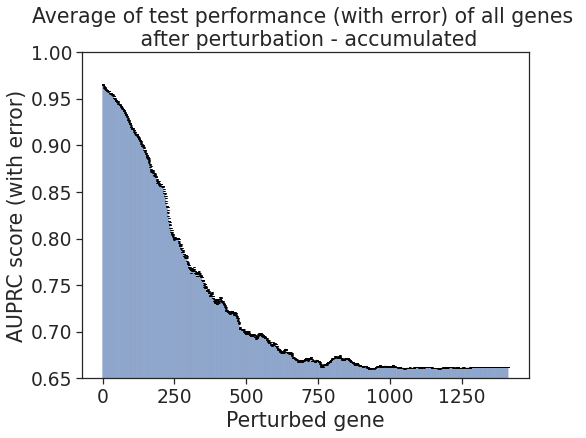

In [17]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Perturbed gene')
plt.title("Average of test performance (with error) of all genes \n after perturbation - accumulated")
# plt.savefig('../figures/3c_accumulated_perturbation_coef_ranked.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

sns.lineplot(data=scores_df, x="gene", y="mean")

In [18]:
import scipy
import pylab
from scipy.misc import derivative

In [19]:
ftr_names = ranked_list

In [20]:
range(len(ranked_list))

range(0, 1413)

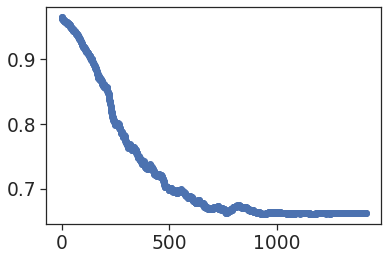

In [21]:
y0 = scipy.interpolate.interp1d(range(len(ftr_names)), scores_df['mean'], kind='nearest')
continuous_x = np.linspace(1, len(ftr_names)-2, len(ftr_names)-2)
plt.scatter(range(len(ftr_names)), scores_df['mean'])

<Figure size 576x432 with 0 Axes>

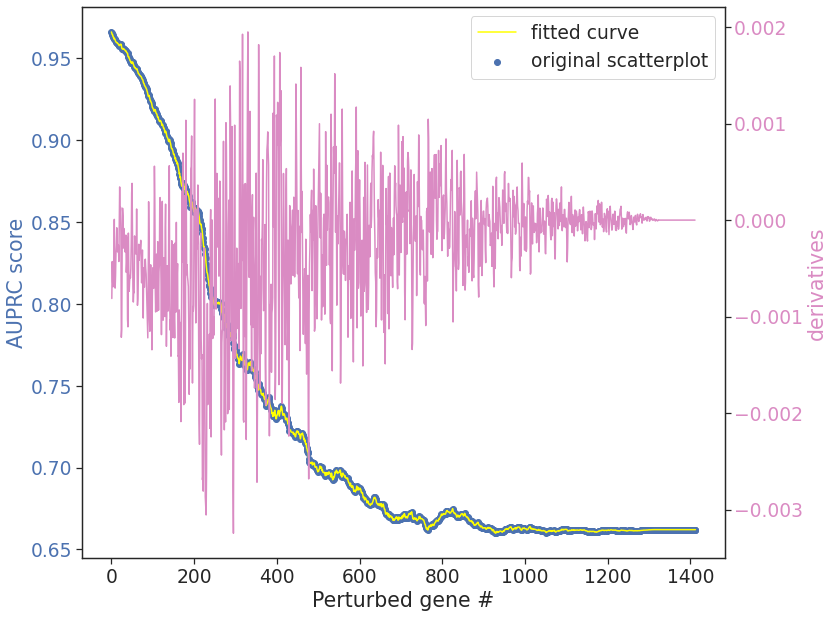

In [22]:
plt.figure(figsize=(8,6))

sns.set(font_scale=1.7, style='ticks')
fig, ax1 = plt.subplots(figsize=(12, 9))

color = sns.color_palette()[0]
ax1.set_xlabel('Perturbed gene #')
ax1.set_ylabel('AUPRC score', color=color)
ax1.scatter(range(len(ftr_names)), scores_df['mean'], label='data point', color=color)
ax1.plot(range(len(ftr_names)), y0(range(len(ftr_names))), label='nearest', color='yellow')
ax1.legend(['fitted curve', 'original scatterplot'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = sns.color_palette()[6]
ax2.set_ylabel('derivatives', color=color)  # we already handled the x-label with ax1
ax2.plot(continuous_x, derivative(y0, continuous_x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('../figures/3d_accumulated_perturbation_derivatives.PDF', bbox_inches='tight')
plt.show()

In [23]:
ftr_names.reverse()

In [24]:
from sklearn.inspection import permutation_importance
# acuumulated perturbation
np.random.seed(42)
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test.copy()

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test_shuffled[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

shuffling Ddah1
shuffled test score: 0.9667 +/- 0.0
shuffling Slc25a13
shuffled test score: 0.9667 +/- 0.0
shuffling Mro
shuffled test score: 0.9667 +/- 0.0
shuffling Ccdc60
shuffled test score: 0.9667 +/- 0.0
shuffling Zfp36l1
shuffled test score: 0.9667 +/- 0.0
shuffling Slc13a1
shuffled test score: 0.9667 +/- 0.0
shuffling Dgkg
shuffled test score: 0.9667 +/- 0.0
shuffling Tgfb2
shuffled test score: 0.9667 +/- 0.0
shuffling Brinp2
shuffled test score: 0.9667 +/- 0.0
shuffling Tril
shuffled test score: 0.9667 +/- 0.0
shuffling Slc2a1
shuffled test score: 0.9667 +/- 0.0
shuffling Nckap1l
shuffled test score: 0.9667 +/- 0.0
shuffling Cnih3
shuffled test score: 0.9667 +/- 0.0
shuffling Hmcn2
shuffled test score: 0.9667 +/- 0.0
shuffling Ret
shuffled test score: 0.9667 +/- 0.0
shuffling Ar
shuffled test score: 0.9667 +/- 0.0
shuffling Gli3
shuffled test score: 0.9667 +/- 0.0
shuffling Has2os
shuffled test score: 0.9667 +/- 0.0
shuffling Nos1
shuffled test score: 0.9667 +/- 0.0
shuffling 

shuffled test score: 0.9667 +/- 0.0
shuffling Nek11
shuffled test score: 0.9668 +/- 0.0
shuffling Wwc1
shuffled test score: 0.9667 +/- 0.0
shuffling Syt10
shuffled test score: 0.9667 +/- 0.0
shuffling Zbbx
shuffled test score: 0.9667 +/- 0.0
shuffling Auts2
shuffled test score: 0.9667 +/- 0.0
shuffling Kcnb2
shuffled test score: 0.9668 +/- 0.0
shuffling Kcnt2
shuffled test score: 0.9668 +/- 0.0
shuffling Man2a1
shuffled test score: 0.9668 +/- 0.0
shuffling Slc25a21
shuffled test score: 0.9668 +/- 0.0
shuffling Lmx1a
shuffled test score: 0.9668 +/- 0.0
shuffling Lgr5
shuffled test score: 0.9668 +/- 0.0
shuffling Nin
shuffled test score: 0.9668 +/- 0.0
shuffling Pvt1
shuffled test score: 0.9668 +/- 0.0
shuffling Ecel1
shuffled test score: 0.9667 +/- 0.0
shuffling Fam189a1
shuffled test score: 0.9667 +/- 0.0
shuffling C030029H02Rik
shuffled test score: 0.9667 +/- 0.0
shuffling Sdk2
shuffled test score: 0.9667 +/- 0.0
shuffling Pde1a
shuffled test score: 0.9667 +/- 0.0
shuffling Cdh11
shuf

shuffled test score: 0.9665 +/- 0.0
shuffling C1ql1
shuffled test score: 0.9665 +/- 0.0
shuffling Nrxn3
shuffled test score: 0.9665 +/- 0.0
shuffling Schip1
shuffled test score: 0.9664 +/- 0.0
shuffling Epha10
shuffled test score: 0.9664 +/- 0.0
shuffling Zswim6
shuffled test score: 0.9664 +/- 0.0
shuffling Frmpd4
shuffled test score: 0.9665 +/- 0.0
shuffling Mthfd1l
shuffled test score: 0.9665 +/- 0.0
shuffling Gm5149
shuffled test score: 0.9665 +/- 0.0
shuffling Spats2l
shuffled test score: 0.9665 +/- 0.0
shuffling Prkg1
shuffled test score: 0.9665 +/- 0.0
shuffling Gpc4
shuffled test score: 0.9665 +/- 0.0
shuffling Scn5a
shuffled test score: 0.9665 +/- 0.0
shuffling Vwa3a
shuffled test score: 0.9665 +/- 0.0
shuffling Slc1a2
shuffled test score: 0.9665 +/- 0.0
shuffling A330102I10Rik
shuffled test score: 0.9665 +/- 0.0
shuffling Fam216b
shuffled test score: 0.9666 +/- 0.0
shuffling Cdh19
shuffled test score: 0.9666 +/- 0.0
shuffling Cdh12
shuffled test score: 0.9666 +/- 0.0
shuffling

shuffled test score: 0.9664 +/- 0.0
shuffling Hlf
shuffled test score: 0.9663 +/- 0.0
shuffling Fmod
shuffled test score: 0.9663 +/- 0.0
shuffling Sorcs3
shuffled test score: 0.9663 +/- 0.0
shuffling Ccdc114
shuffled test score: 0.9663 +/- 0.0
shuffling Atrnl1
shuffled test score: 0.9663 +/- 0.0
shuffling Sema5a
shuffled test score: 0.9663 +/- 0.0
shuffling Sparc
shuffled test score: 0.9663 +/- 0.0
shuffling Agt
shuffled test score: 0.9663 +/- 0.0
shuffling Plcl1
shuffled test score: 0.9663 +/- 0.0
shuffling Lrrc7
shuffled test score: 0.9663 +/- 0.0
shuffling Kcnh7
shuffled test score: 0.9662 +/- 0.0
shuffling Zfp423
shuffled test score: 0.9662 +/- 0.0
shuffling Syt6
shuffled test score: 0.9662 +/- 0.0
shuffling Camk4
shuffled test score: 0.9662 +/- 0.0
shuffling Gm10714
shuffled test score: 0.9663 +/- 0.0
shuffling Tmem196
shuffled test score: 0.9663 +/- 0.0
shuffling Dipk2b
shuffled test score: 0.9663 +/- 0.0
shuffling Sel1l3
shuffled test score: 0.9663 +/- 0.0
shuffling Strip2
shuff

shuffled test score: 0.9661 +/- 0.0
shuffling Epha6
shuffled test score: 0.9661 +/- 0.0
shuffling Gab1
shuffled test score: 0.9661 +/- 0.0
shuffling Col4a5
shuffled test score: 0.966 +/- 0.0
shuffling Ntn1
shuffled test score: 0.966 +/- 0.0
shuffling Asb4
shuffled test score: 0.9661 +/- 0.0
shuffling Phactr1
shuffled test score: 0.9661 +/- 0.0
shuffling Cpne7
shuffled test score: 0.9661 +/- 0.0
shuffling Vwc2l
shuffled test score: 0.966 +/- 0.0
shuffling Nox4
shuffled test score: 0.9661 +/- 0.0
shuffling Grm1
shuffled test score: 0.966 +/- 0.0
shuffling Patj
shuffled test score: 0.966 +/- 0.0
shuffling Cpne5
shuffled test score: 0.966 +/- 0.0
shuffling Nfia
shuffled test score: 0.966 +/- 0.0
shuffling Cdkl5
shuffled test score: 0.9661 +/- 0.0
shuffling Etv1
shuffled test score: 0.9661 +/- 0.0
shuffling Ildr2
shuffled test score: 0.9661 +/- 0.0
shuffling 6430628N08Rik
shuffled test score: 0.9661 +/- 0.0
shuffling Ptpn3
shuffled test score: 0.966 +/- 0.0
shuffling Khdrbs3
shuffled test s

shuffled test score: 0.9662 +/- 0.0
shuffling Vcan
shuffled test score: 0.9662 +/- 0.0
shuffling T2
shuffled test score: 0.9662 +/- 0.0
shuffling Slc1a3
shuffled test score: 0.9662 +/- 0.0
shuffling Ldb2
shuffled test score: 0.9661 +/- 0.0
shuffling Dbx2
shuffled test score: 0.9661 +/- 0.0
shuffling Tmem200a
shuffled test score: 0.9661 +/- 0.0
shuffling Gm45341
shuffled test score: 0.9661 +/- 0.0
shuffling Lrig1
shuffled test score: 0.9661 +/- 0.0
shuffling Adap2os
shuffled test score: 0.9661 +/- 0.0
shuffling Tmtc2
shuffled test score: 0.966 +/- 0.0
shuffling Ghrh
shuffled test score: 0.9659 +/- 0.0
shuffling Cntn5
shuffled test score: 0.9657 +/- 0.0
shuffling Vat1l
shuffled test score: 0.9657 +/- 0.0
shuffling Spink10
shuffled test score: 0.9657 +/- 0.0
shuffling Lzts1
shuffled test score: 0.9657 +/- 0.0
shuffling Casp8
shuffled test score: 0.9657 +/- 0.0
shuffling Myl9
shuffled test score: 0.9656 +/- 0.0
shuffling Pard3b
shuffled test score: 0.9655 +/- 0.0
shuffling 1700042O10Rik
sh

shuffled test score: 0.9628 +/- 0.0
shuffling Adcy2
shuffled test score: 0.9627 +/- 0.0
shuffling Khdrbs2
shuffled test score: 0.9625 +/- 0.0
shuffling Syt2
shuffled test score: 0.9626 +/- 0.0
shuffling Zmat4
shuffled test score: 0.9626 +/- 0.0
shuffling Pecam1
shuffled test score: 0.9624 +/- 0.0
shuffling Ebf1
shuffled test score: 0.9623 +/- 0.0
shuffling Csf3r
shuffled test score: 0.9622 +/- 0.0
shuffling Adamts12
shuffled test score: 0.9623 +/- 0.0
shuffling Jam2
shuffled test score: 0.9623 +/- 0.0
shuffling Igfbp7
shuffled test score: 0.9622 +/- 0.0
shuffling Csf1r
shuffled test score: 0.9623 +/- 0.0
shuffling Scn7a
shuffled test score: 0.9622 +/- 0.0
shuffling Kcnc2
shuffled test score: 0.962 +/- 0.0
shuffling Neto1
shuffled test score: 0.9619 +/- 0.0
shuffling Cntnap4
shuffled test score: 0.9618 +/- 0.0
shuffling Grm8
shuffled test score: 0.9616 +/- 0.0
shuffling Tgfbr1
shuffled test score: 0.9616 +/- 0.0
shuffling Nrp2
shuffled test score: 0.9616 +/- 0.0
shuffling 9330185C12Rik


shuffled test score: 0.9609 +/- 0.0
shuffling Otx2os1
shuffled test score: 0.9608 +/- 0.0
shuffling Nostrin
shuffled test score: 0.9607 +/- 0.0
shuffling Gm12027
shuffled test score: 0.9608 +/- 0.0
shuffling Dgkk
shuffled test score: 0.9608 +/- 0.0
shuffling Mamdc2
shuffled test score: 0.9607 +/- 0.0
shuffling Rbfox1
shuffled test score: 0.9609 +/- 0.0
shuffling Kcnmb2
shuffled test score: 0.9611 +/- 0.0
shuffling Sox5os4
shuffled test score: 0.9611 +/- 0.0
shuffling Unc13b
shuffled test score: 0.9611 +/- 0.0
shuffling Ttc29
shuffled test score: 0.9612 +/- 0.0
shuffling Thsd4
shuffled test score: 0.9612 +/- 0.0
shuffling Gm29865
shuffled test score: 0.9613 +/- 0.0
shuffling Siglech
shuffled test score: 0.9613 +/- 0.0
shuffling Cd38
shuffled test score: 0.9612 +/- 0.0
shuffling Gm6145
shuffled test score: 0.9612 +/- 0.0
shuffling Ror1
shuffled test score: 0.9613 +/- 0.0
shuffling Itga9
shuffled test score: 0.9613 +/- 0.0
shuffling Clic4
shuffled test score: 0.9614 +/- 0.0
shuffling Sema

shuffled test score: 0.9574 +/- 0.0001
shuffling Gm39653
shuffled test score: 0.9572 +/- 0.0
shuffling Tbx19
shuffled test score: 0.9567 +/- 0.0
shuffling Gm29773
shuffled test score: 0.9564 +/- 0.0
shuffling St8sia2
shuffled test score: 0.9565 +/- 0.0
shuffling Megf11
shuffled test score: 0.9566 +/- 0.0
shuffling Lgals9
shuffled test score: 0.9565 +/- 0.0
shuffling Acss1
shuffled test score: 0.9564 +/- 0.0
shuffling Tns3
shuffled test score: 0.9564 +/- 0.0
shuffling Gm34544
shuffled test score: 0.9563 +/- 0.0001
shuffling Cables1
shuffled test score: 0.9562 +/- 0.0
shuffling Ramp3
shuffled test score: 0.9563 +/- 0.0
shuffling Fbxl13
shuffled test score: 0.9563 +/- 0.0
shuffling Nms
shuffled test score: 0.9564 +/- 0.0
shuffling Pla2g7
shuffled test score: 0.9564 +/- 0.0
shuffling Ak9
shuffled test score: 0.9563 +/- 0.0
shuffling C79798
shuffled test score: 0.9561 +/- 0.0
shuffling Acvrl1
shuffled test score: 0.9559 +/- 0.0
shuffling 1700018A04Rik
shuffled test score: 0.9558 +/- 0.0
shu

shuffled test score: 0.7991 +/- 0.0002
shuffling Olfr1369-ps1
shuffled test score: 0.7933 +/- 0.0002
shuffling Mrc1
shuffled test score: 0.792 +/- 0.0001
shuffling Gm16272
shuffled test score: 0.7812 +/- 0.0004
shuffling 1700028P14Rik
shuffled test score: 0.7739 +/- 0.0003
shuffling Srgn
shuffled test score: 0.7662 +/- 0.0002
shuffling Nes
shuffled test score: 0.7632 +/- 0.0002
shuffling Gm34455
shuffled test score: 0.7508 +/- 0.0007
shuffling Csta2
shuffled test score: 0.7386 +/- 0.0004
shuffling Slc13a4
shuffled test score: 0.7346 +/- 0.0004
shuffling Gm30613
shuffled test score: 0.7247 +/- 0.0005
shuffling Fndc3c1
shuffled test score: 0.7217 +/- 0.0002
shuffling Adam2
shuffled test score: 0.7004 +/- 0.0008
shuffling AW112010
shuffled test score: 0.6883 +/- 0.0006
shuffling Slc5a4b
shuffled test score: 0.6637 +/- 0.0013


In [52]:
feature_names = ranked_list

In [59]:
feature_names.reverse()

In [85]:
feature_names[0:80]

['Slc5a4b',
 'AW112010',
 'Adam2',
 'Fndc3c1',
 'Gm30613',
 'Slc13a4',
 'Csta2',
 'Gm34455',
 'Nes',
 'Srgn',
 '1700028P14Rik',
 'Gm16272',
 'Mrc1',
 'Olfr1369-ps1',
 'Cd34',
 'Rgs5',
 'Pamr1',
 'Nek5',
 'Tmem45b',
 '1700123O12Rik',
 'Dthd1',
 'Cavin1',
 'Hpgd',
 'Morrbid',
 'Rep15',
 '2310039L15Rik',
 'Lrrc71',
 'Acat3',
 'D5Ertd615e',
 'Rtp3',
 'Slc22a8',
 'Ifitm3',
 'Akr1b8',
 'Epsti1',
 'Gimap6',
 'Gm14582',
 'Pappa2',
 'Hormad1',
 'Gm36431',
 'Efcab11',
 'Myh3',
 'Ttc6',
 'Gm4681',
 'Gm4566',
 '4930438E09Rik',
 'Slco1a4',
 'Zic4',
 'Ltbp1',
 'Gjb6',
 'Postn',
 'Foxq1',
 'Greb1',
 'Col6a5',
 'Ccdc3',
 'Grpr',
 'Erg',
 'Vipr2',
 'C1qa',
 'Zfp366',
 'Tnfsf4',
 'Ros1',
 'Col12a1',
 '2010001K21Rik',
 'Knl1',
 'Dnah14',
 '4930500H12Rik',
 'Klf2',
 'Gm4951',
 'Tbx3os1',
 'Cd247',
 'Ly6c1',
 'Tmem212',
 'Adra1b',
 'Gm48228',
 'Cdhr3',
 'Gm6260',
 'Fn1',
 'Gm2762',
 'Bcl11b',
 'Gm39185']

In [61]:
feature_names.index('AC150683.1')

276

In [58]:
ranked_list.index('Crh')

1307

In [27]:
X_test_shuffle_original = X_test_shuffled.copy()

In [28]:
X_test_shuffled[ftr_names[1000:]] = X_test.iloc[:, 1000:]

In [29]:
y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
auc(recall, precision)

0.869524752830388

In [30]:
X_test_shuffled = X_test_shuffle_original.copy()

In [31]:
X_test_shuffled[ftr_names[1318:]] = X_test.iloc[:, 1318:]
y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
auc(recall, precision)

0.8627846492444329

In [32]:
file = open('../results/cell_type_best/Neuron_scores_accumulated_reversed.save', 'wb')
pickle.dump(scores, file)
file.close()

scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ftr_names

In [33]:
scores_df

,0,1,2,3,4,5,6,7,8,9,mean,std,gene
0,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Ddah1
1,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Slc25a13
2,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Mro
3,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Ccdc60
4,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Zfp36l1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,0.725818,0.724893,0.724693,0.724591,0.724491,0.723868,0.725408,0.724513,0.724375,0.724733,0.724738,5.160253e-04,Gm30613
1409,0.721578,0.721656,0.722149,0.721653,0.721548,0.721705,0.721502,0.721653,0.721625,0.721635,0.721670,1.691954e-04,Fndc3c1
1410,0.699932,0.701303,0.701462,0.701092,0.700492,0.700846,0.698892,0.700285,0.700629,0.699046,0.700398,8.379243e-04,Adam2
1411,0.688007,0.688562,0.688744,0.688804,0.687911,0.687606,0.689295,0.688838,0.688122,0.687479,0.688337,5.665294e-04,AW112010


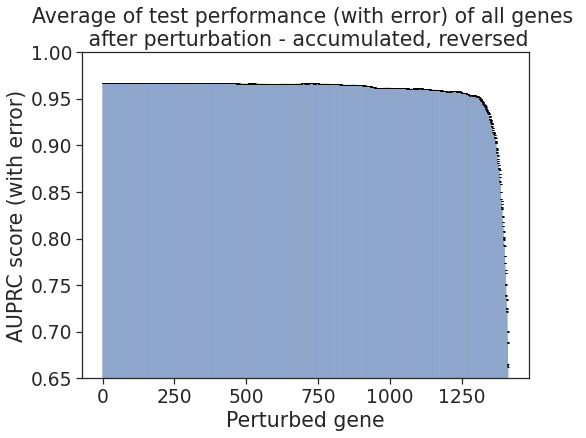

In [34]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(1413), scores_df['mean'] , yerr=scores_df['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Perturbed gene')
plt.title("Average of test performance (with error) of all genes \n after perturbation - accumulated, reversed")
#plt.savefig('../figures/3c_accumulated_perturbation_coef_ranked_reversed.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

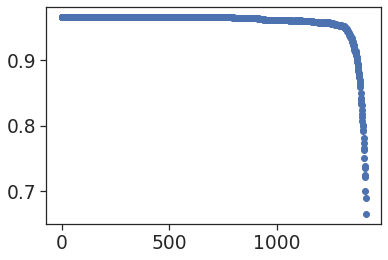

In [35]:
y0 = scipy.interpolate.interp1d(range(len(ftr_names)), scores_df['mean'], kind='nearest')
continuous_x = np.linspace(1, len(ftr_names)-2, len(ftr_names)-2)
plt.scatter(range(len(ftr_names)), scores_df['mean'])

In [36]:
scores_df

,0,1,2,3,4,5,6,7,8,9,mean,std,gene
0,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Ddah1
1,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Slc25a13
2,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Mro
3,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Ccdc60
4,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,0.966723,3.510833e-17,Zfp36l1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,0.725818,0.724893,0.724693,0.724591,0.724491,0.723868,0.725408,0.724513,0.724375,0.724733,0.724738,5.160253e-04,Gm30613
1409,0.721578,0.721656,0.722149,0.721653,0.721548,0.721705,0.721502,0.721653,0.721625,0.721635,0.721670,1.691954e-04,Fndc3c1
1410,0.699932,0.701303,0.701462,0.701092,0.700492,0.700846,0.698892,0.700285,0.700629,0.699046,0.700398,8.379243e-04,Adam2
1411,0.688007,0.688562,0.688744,0.688804,0.687911,0.687606,0.689295,0.688838,0.688122,0.687479,0.688337,5.665294e-04,AW112010


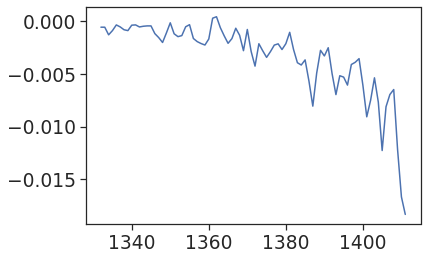

In [86]:
plt.plot(continuous_x[-80:], derivative(y0, continuous_x[-80:]))

In [84]:
ftr_names[:80]

Index(['Avp', 'Pmch', 'Oxt', 'Hcrt', 'Sst', 'Cartpt', 'Pomc', 'Trh', 'Tac2',
       'Npy', 'Gal', 'Inpp5k', 'Ptgds', 'Flt1', 'Vtn', 'Hba-a1', 'Slco1a4',
       'Ebf1', 'C1qa', 'Ly6c1', 'Hbb-bs', 'Tac1', 'Vip', 'Adgrl4', 'Nts',
       'Hdc', 'Mecom', 'Col25a1', 'Ly6a', 'Gm32647', 'Cldn5', 'Pla2g6', 'Ctss',
       'Nfe2l2', 'Meis2', 'Il1rapl2', 'Adarb2', 'Apod', 'Ntng1',
       'A530053G22Rik', 'Gm16272', 'Zfp804b', 'Kcnip4', 'Gm34544', 'Hexb',
       'Lamb3', 'Gm28526', 'Npsr1', 'Rgs5', 'Itm2a', 'Cfap299', 'Cck',
       'Gm34455', 'Col23a1', 'Apoe', 'Ebf2', 'Lef1', 'Mthfd1l', 'Pbld1', 'Npl',
       'Ghrh', 'Plp1', 'Etl4', 'Slc47a1', 'B230312C02Rik', 'Ly86', 'Tafa1',
       'Crh', 'Gpc5', 'Ranbp3l', 'Acat3', 'Cx3cr1', 'Nnat', 'Inpp5d',
       'AC150683.1', 'Bnc2', 'Grik1', 'Foxp2', 'Grp', 'Galntl6'],
      dtype='object')

In [82]:
derivative(y0, continuous_x[-80:])

array([-0.00055649, -0.00055958, -0.0012813 , -0.00087868, -0.00034193,
       -0.00053042, -0.00080041, -0.00088128, -0.00036606, -0.00034028,
       -0.00053475, -0.00046882, -0.00043471, -0.00043528, -0.00116865,
       -0.00154483, -0.00201025, -0.00110162, -0.00014004, -0.00118273,
       -0.00145486, -0.0013553 , -0.00051743, -0.00031926, -0.00162993,
       -0.00192694, -0.00211102, -0.00225009, -0.00167816,  0.00029745,
        0.00043433, -0.00060589, -0.0013796 , -0.00208789, -0.00164193,
       -0.00065713, -0.00132484, -0.00278765, -0.00077453, -0.00287314,
       -0.0042529 , -0.0021265 , -0.00279948, -0.00342159, -0.00287723,
       -0.00225705, -0.00213726, -0.0026783 , -0.00212379, -0.00104413,
       -0.00267853, -0.00392982, -0.00414744, -0.00366078, -0.00567844,
       -0.00805205, -0.0049265 , -0.00275416, -0.00328578, -0.00250725,
       -0.00496559, -0.00695721, -0.00516485, -0.00529616, -0.0060544 ,
       -0.00409867, -0.00389254, -0.00354348, -0.00607555, -0.00

<Figure size 576x432 with 0 Axes>

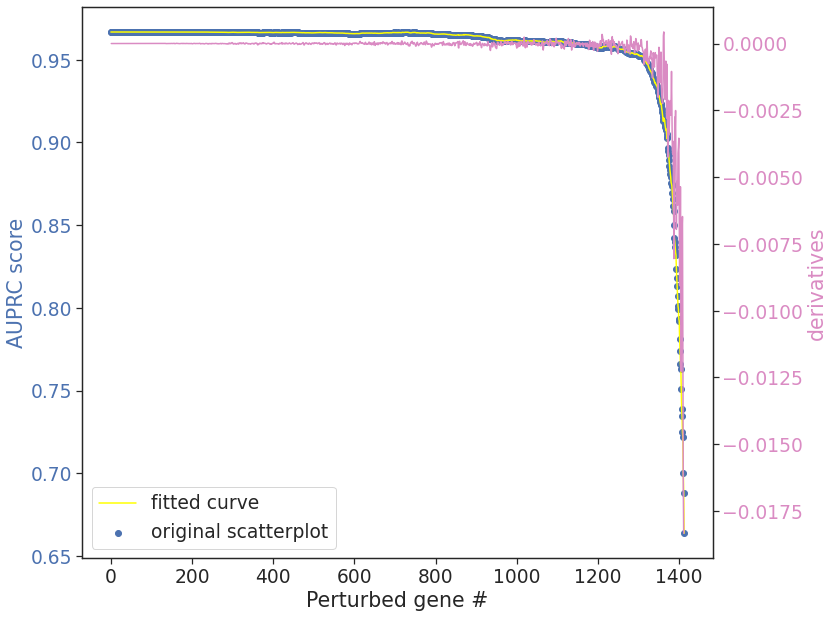

In [37]:
plt.figure(figsize=(8,6))

sns.set(font_scale=1.7, style='ticks')
fig, ax1 = plt.subplots(figsize=(12, 9))

color = sns.color_palette()[0]
ax1.set_xlabel('Perturbed gene #')
ax1.set_ylabel('AUPRC score', color=color)
ax1.scatter(range(len(ftr_names)), scores_df['mean'], label='data point', color=color)
ax1.plot(range(len(ftr_names)), y0(range(len(ftr_names))), label='nearest', color='yellow')
ax1.legend(['fitted curve', 'original scatterplot'])
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = sns.color_palette()[6]
ax2.set_ylabel('derivatives', color=color)  # we already handled the x-label with ax1
ax2.plot(continuous_x, derivative(y0, continuous_x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.savefig('../figures/3d_accumulated_perturbation_derivatives_reversed.PDF', bbox_inches='tight')
plt.show()

In [38]:
X_test_shuffled = X_test_shuffle_original.copy()

In [39]:
ranked_list.reverse()

In [40]:
from sklearn.inspection import permutation_importance
# acuumulated perturbation
np.random.seed(42)

ftr_names = ranked_list
nr_runs = 10

scores = np.zeros([len(ftr_names), nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

# loop through the features
X_test_shuffled = X_test_shuffle_original.copy()

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
    for j in range(nr_runs):
        X_test_shuffled[ftr_names[i]] = X_test[ftr_names[i]]
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),4),'+/-', np.around(np.std(auprc_scores),4))
    scores[i] = auprc_scores

shuffling Slc5a4b
shuffled test score: 0.6875 +/- 0.0
shuffling AW112010
shuffled test score: 0.699 +/- 0.0
shuffling Adam2
shuffled test score: 0.7216 +/- 0.0
shuffling Fndc3c1
shuffled test score: 0.7247 +/- 0.0
shuffling Gm30613
shuffled test score: 0.7346 +/- 0.0
shuffling Slc13a4
shuffled test score: 0.7393 +/- 0.0
shuffling Csta2
shuffled test score: 0.7506 +/- 0.0
shuffling Gm34455
shuffled test score: 0.763 +/- 0.0
shuffling Nes
shuffled test score: 0.7659 +/- 0.0
shuffling Srgn
shuffled test score: 0.774 +/- 0.0
shuffling 1700028P14Rik
shuffled test score: 0.781 +/- 0.0
shuffling Gm16272
shuffled test score: 0.792 +/- 0.0
shuffling Mrc1
shuffled test score: 0.7932 +/- 0.0
shuffling Olfr1369-ps1
shuffled test score: 0.7993 +/- 0.0
shuffling Cd34
shuffled test score: 0.8009 +/- 0.0
shuffling Rgs5
shuffled test score: 0.8074 +/- 0.0
shuffling Pamr1
shuffled test score: 0.8134 +/- 0.0
shuffling Nek5
shuffled test score: 0.8181 +/- 0.0
shuffling Tmem45b
shuffled test score: 0.8243 

shuffled test score: 0.9562 +/- 0.0
shuffling Gm34544
shuffled test score: 0.9564 +/- 0.0
shuffling Tns3
shuffled test score: 0.9564 +/- 0.0
shuffling Acss1
shuffled test score: 0.9565 +/- 0.0
shuffling Lgals9
shuffled test score: 0.9566 +/- 0.0
shuffling Megf11
shuffled test score: 0.9565 +/- 0.0
shuffling St8sia2
shuffled test score: 0.9564 +/- 0.0
shuffling Gm29773
shuffled test score: 0.9567 +/- 0.0
shuffling Tbx19
shuffled test score: 0.9571 +/- 0.0
shuffling Gm39653
shuffled test score: 0.9573 +/- 0.0
shuffling Greb1l
shuffled test score: 0.9575 +/- 0.0
shuffling 4930445E18Rik
shuffled test score: 0.9577 +/- 0.0
shuffling Rreb1
shuffled test score: 0.9577 +/- 0.0
shuffling B230312C02Rik
shuffled test score: 0.9579 +/- 0.0
shuffling Esam
shuffled test score: 0.9578 +/- 0.0
shuffling Npy1r
shuffled test score: 0.958 +/- 0.0
shuffling Sphkap
shuffled test score: 0.9579 +/- 0.0
shuffling Myo1e
shuffled test score: 0.9579 +/- 0.0
shuffling Prom1
shuffled test score: 0.958 +/- 0.0
shuf

shuffled test score: 0.9611 +/- 0.0
shuffling Unc13b
shuffled test score: 0.9611 +/- 0.0
shuffling Sox5os4
shuffled test score: 0.961 +/- 0.0
shuffling Kcnmb2
shuffled test score: 0.9609 +/- 0.0
shuffling Rbfox1
shuffled test score: 0.9607 +/- 0.0
shuffling Mamdc2
shuffled test score: 0.9607 +/- 0.0
shuffling Dgkk
shuffled test score: 0.9607 +/- 0.0
shuffling Gm12027
shuffled test score: 0.9607 +/- 0.0
shuffling Nostrin
shuffled test score: 0.9608 +/- 0.0
shuffling Otx2os1
shuffled test score: 0.9609 +/- 0.0
shuffling Slc26a7
shuffled test score: 0.961 +/- 0.0
shuffling Gm12082
shuffled test score: 0.9609 +/- 0.0
shuffling Bmp6
shuffled test score: 0.961 +/- 0.0
shuffling Runx1t1
shuffled test score: 0.961 +/- 0.0
shuffling Ebf3
shuffled test score: 0.961 +/- 0.0
shuffling Ak7
shuffled test score: 0.9612 +/- 0.0
shuffling Gm32828
shuffled test score: 0.961 +/- 0.0
shuffling Ikzf1
shuffled test score: 0.961 +/- 0.0
shuffling Mbp
shuffled test score: 0.9608 +/- 0.0
shuffling Abcc4
shuffl

shuffled test score: 0.9623 +/- 0.0
shuffling Jam2
shuffled test score: 0.9622 +/- 0.0
shuffling Adamts12
shuffled test score: 0.9622 +/- 0.0
shuffling Csf3r
shuffled test score: 0.9623 +/- 0.0
shuffling Ebf1
shuffled test score: 0.9624 +/- 0.0
shuffling Pecam1
shuffled test score: 0.9626 +/- 0.0
shuffling Zmat4
shuffled test score: 0.9626 +/- 0.0
shuffling Syt2
shuffled test score: 0.9625 +/- 0.0
shuffling Khdrbs2
shuffled test score: 0.9627 +/- 0.0
shuffling Adcy2
shuffled test score: 0.9628 +/- 0.0
shuffling Kntc1
shuffled test score: 0.9633 +/- 0.0
shuffling Tll1
shuffled test score: 0.9632 +/- 0.0
shuffling Gm26871
shuffled test score: 0.9634 +/- 0.0
shuffling Col11a1
shuffled test score: 0.9634 +/- 0.0
shuffling Cachd1
shuffled test score: 0.9635 +/- 0.0
shuffling Pla2g4a
shuffled test score: 0.9634 +/- 0.0
shuffling Ptprg
shuffled test score: 0.9633 +/- 0.0
shuffling Cntnap5b
shuffled test score: 0.9634 +/- 0.0
shuffling Rasgef1b
shuffled test score: 0.9635 +/- 0.0
shuffling Trp

shuffled test score: 0.9661 +/- 0.0
shuffling Adap2os
shuffled test score: 0.9661 +/- 0.0
shuffling Lrig1
shuffled test score: 0.9661 +/- 0.0
shuffling Gm45341
shuffled test score: 0.9661 +/- 0.0
shuffling Tmem200a
shuffled test score: 0.9661 +/- 0.0
shuffling Dbx2
shuffled test score: 0.9662 +/- 0.0
shuffling Ldb2
shuffled test score: 0.9662 +/- 0.0
shuffling Slc1a3
shuffled test score: 0.9662 +/- 0.0
shuffling T2
shuffled test score: 0.9662 +/- 0.0
shuffling Vcan
shuffled test score: 0.9662 +/- 0.0
shuffling Ebf2
shuffled test score: 0.9662 +/- 0.0
shuffling Eps8
shuffled test score: 0.9661 +/- 0.0
shuffling C1ql3
shuffled test score: 0.966 +/- 0.0
shuffling Lrrtm4
shuffled test score: 0.9661 +/- 0.0
shuffling Galnt17
shuffled test score: 0.9661 +/- 0.0
shuffling Fbxl7
shuffled test score: 0.9661 +/- 0.0
shuffling Cyyr1
shuffled test score: 0.9661 +/- 0.0
shuffling Ano5
shuffled test score: 0.966 +/- 0.0
shuffling Adamts19
shuffled test score: 0.966 +/- 0.0
shuffling Galnt18
shuffled

shuffled test score: 0.966 +/- 0.0
shuffling Grm1
shuffled test score: 0.9661 +/- 0.0
shuffling Nox4
shuffled test score: 0.966 +/- 0.0
shuffling Vwc2l
shuffled test score: 0.9661 +/- 0.0
shuffling Cpne7
shuffled test score: 0.9661 +/- 0.0
shuffling Phactr1
shuffled test score: 0.9661 +/- 0.0
shuffling Asb4
shuffled test score: 0.966 +/- 0.0
shuffling Ntn1
shuffled test score: 0.966 +/- 0.0
shuffling Col4a5
shuffled test score: 0.9661 +/- 0.0
shuffling Gab1
shuffled test score: 0.9661 +/- 0.0
shuffling Epha6
shuffled test score: 0.9661 +/- 0.0
shuffling Ctss
shuffled test score: 0.9661 +/- 0.0
shuffling Cntnap3
shuffled test score: 0.9661 +/- 0.0
shuffling Fbn2
shuffled test score: 0.966 +/- 0.0
shuffling 9530059O14Rik
shuffled test score: 0.966 +/- 0.0
shuffling Osbpl3
shuffled test score: 0.966 +/- 0.0
shuffling Enox2
shuffled test score: 0.966 +/- 0.0
shuffling Calb1
shuffled test score: 0.966 +/- 0.0
shuffling Atp2b4
shuffled test score: 0.9659 +/- 0.0
shuffling 4930545L23Rik
shuff

shuffled test score: 0.9663 +/- 0.0
shuffling Lrrc7
shuffled test score: 0.9663 +/- 0.0
shuffling Plcl1
shuffled test score: 0.9663 +/- 0.0
shuffling Agt
shuffled test score: 0.9663 +/- 0.0
shuffling Sparc
shuffled test score: 0.9663 +/- 0.0
shuffling Sema5a
shuffled test score: 0.9663 +/- 0.0
shuffling Atrnl1
shuffled test score: 0.9663 +/- 0.0
shuffling Ccdc114
shuffled test score: 0.9663 +/- 0.0
shuffling Sorcs3
shuffled test score: 0.9663 +/- 0.0
shuffling Fmod
shuffled test score: 0.9663 +/- 0.0
shuffling Hlf
shuffled test score: 0.9664 +/- 0.0
shuffling Rerg
shuffled test score: 0.9664 +/- 0.0
shuffling Spag16
shuffled test score: 0.9664 +/- 0.0
shuffling 6330411D24Rik
shuffled test score: 0.9664 +/- 0.0
shuffling Unc5cl
shuffled test score: 0.9664 +/- 0.0
shuffling Dnah7b
shuffled test score: 0.9664 +/- 0.0
shuffling Hnf4g
shuffled test score: 0.9665 +/- 0.0
shuffling Dpf3
shuffled test score: 0.9665 +/- 0.0
shuffling Elavl4
shuffled test score: 0.9665 +/- 0.0
shuffling Crim1
sh

shuffled test score: 0.9665 +/- 0.0
shuffling Prkg1
shuffled test score: 0.9665 +/- 0.0
shuffling Spats2l
shuffled test score: 0.9665 +/- 0.0
shuffling Gm5149
shuffled test score: 0.9665 +/- 0.0
shuffling Mthfd1l
shuffled test score: 0.9665 +/- 0.0
shuffling Frmpd4
shuffled test score: 0.9664 +/- 0.0
shuffling Zswim6
shuffled test score: 0.9664 +/- 0.0
shuffling Epha10
shuffled test score: 0.9664 +/- 0.0
shuffling Schip1
shuffled test score: 0.9665 +/- 0.0
shuffling Nrxn3
shuffled test score: 0.9665 +/- 0.0
shuffling C1ql1
shuffled test score: 0.9665 +/- 0.0
shuffling Tcf7l2
shuffled test score: 0.9665 +/- 0.0
shuffling Sh3rf1
shuffled test score: 0.9665 +/- 0.0
shuffling 4930467D21Rik
shuffled test score: 0.9665 +/- 0.0
shuffling Lair1
shuffled test score: 0.9665 +/- 0.0
shuffling 9330111N05Rik
shuffled test score: 0.9665 +/- 0.0
shuffling Gm42439
shuffled test score: 0.9665 +/- 0.0
shuffling Insyn2b
shuffled test score: 0.9665 +/- 0.0
shuffling Grip1
shuffled test score: 0.9666 +/- 0

shuffled test score: 0.9668 +/- 0.0
shuffling Lmx1a
shuffled test score: 0.9668 +/- 0.0
shuffling Slc25a21
shuffled test score: 0.9668 +/- 0.0
shuffling Man2a1
shuffled test score: 0.9668 +/- 0.0
shuffling Kcnt2
shuffled test score: 0.9668 +/- 0.0
shuffling Kcnb2
shuffled test score: 0.9667 +/- 0.0
shuffling Auts2
shuffled test score: 0.9667 +/- 0.0
shuffling Zbbx
shuffled test score: 0.9667 +/- 0.0
shuffling Syt10
shuffled test score: 0.9667 +/- 0.0
shuffling Wwc1
shuffled test score: 0.9668 +/- 0.0
shuffling Nek11
shuffled test score: 0.9667 +/- 0.0
shuffling Alk
shuffled test score: 0.9667 +/- 0.0
shuffling Zfp385b
shuffled test score: 0.9667 +/- 0.0
shuffling Gm48321
shuffled test score: 0.9667 +/- 0.0
shuffling Sh3rf3
shuffled test score: 0.9667 +/- 0.0
shuffling Kcnj10
shuffled test score: 0.9667 +/- 0.0
shuffling Tcerg1l
shuffled test score: 0.9667 +/- 0.0
shuffling Gpr101
shuffled test score: 0.9667 +/- 0.0
shuffling Cntnap5a
shuffled test score: 0.9667 +/- 0.0
shuffling Efna5


shuffled test score: 0.9667 +/- 0.0
shuffling Slc2a1
shuffled test score: 0.9667 +/- 0.0
shuffling Tril
shuffled test score: 0.9667 +/- 0.0
shuffling Brinp2
shuffled test score: 0.9667 +/- 0.0
shuffling Tgfb2
shuffled test score: 0.9667 +/- 0.0
shuffling Dgkg
shuffled test score: 0.9667 +/- 0.0
shuffling Slc13a1
shuffled test score: 0.9667 +/- 0.0
shuffling Zfp36l1
shuffled test score: 0.9667 +/- 0.0
shuffling Ccdc60
shuffled test score: 0.9667 +/- 0.0
shuffling Mro
shuffled test score: 0.9667 +/- 0.0
shuffling Slc25a13
shuffled test score: 0.9667 +/- 0.0
shuffling Ddah1
shuffled test score: 0.9667 +/- 0.0


In [41]:
ftr_names.index('Dhdh')

695

In [42]:
ftr_names[0:80]

['Slc5a4b',
 'AW112010',
 'Adam2',
 'Fndc3c1',
 'Gm30613',
 'Slc13a4',
 'Csta2',
 'Gm34455',
 'Nes',
 'Srgn',
 '1700028P14Rik',
 'Gm16272',
 'Mrc1',
 'Olfr1369-ps1',
 'Cd34',
 'Rgs5',
 'Pamr1',
 'Nek5',
 'Tmem45b',
 '1700123O12Rik',
 'Dthd1',
 'Cavin1',
 'Hpgd',
 'Morrbid',
 'Rep15',
 '2310039L15Rik',
 'Lrrc71',
 'Acat3',
 'D5Ertd615e',
 'Rtp3',
 'Slc22a8',
 'Ifitm3',
 'Akr1b8',
 'Epsti1',
 'Gimap6',
 'Gm14582',
 'Pappa2',
 'Hormad1',
 'Gm36431',
 'Efcab11',
 'Myh3',
 'Ttc6',
 'Gm4681',
 'Gm4566',
 '4930438E09Rik',
 'Slco1a4',
 'Zic4',
 'Ltbp1',
 'Gjb6',
 'Postn',
 'Foxq1',
 'Greb1',
 'Col6a5',
 'Ccdc3',
 'Grpr',
 'Erg',
 'Vipr2',
 'C1qa',
 'Zfp366',
 'Tnfsf4',
 'Ros1',
 'Col12a1',
 '2010001K21Rik',
 'Knl1',
 'Dnah14',
 '4930500H12Rik',
 'Klf2',
 'Gm4951',
 'Tbx3os1',
 'Cd247',
 'Ly6c1',
 'Tmem212',
 'Adra1b',
 'Gm48228',
 'Cdhr3',
 'Gm6260',
 'Fn1',
 'Gm2762',
 'Bcl11b',
 'Gm39185']

In [43]:
file = open('../results/cell_type_best/Neuron_scores_reconstituted.save', 'wb')
pickle.dump(scores, file)
file.close()

scores_df = pd.DataFrame(scores)
scores_df['mean'] = scores_df.mean(axis=1)
scores_df['std'] = scores_df.std(axis=1)
scores_df['gene'] = ftr_names

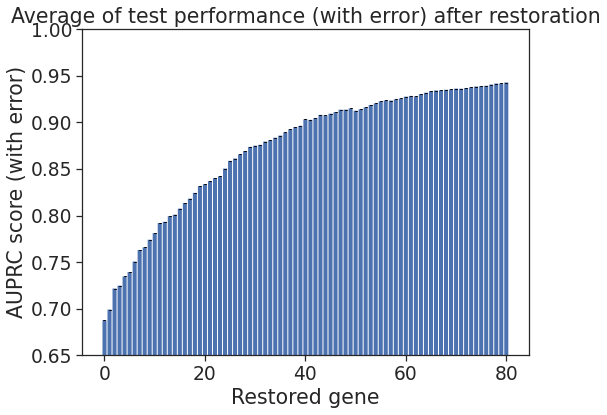

In [45]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.7, style='ticks')

plt.bar(np.arange(81), scores_df.loc[0:80,:]['mean'] , yerr=scores_df.loc[0:80,:]['std'], snap=False, capsize=1,
        color=sns.color_palette()[0], 
        edgecolor=sns.color_palette()[0],
        linewidth=0.005,
        ecolor='black')

# plt.xticks(np.arange(X.shape[1]),X.columns)
plt.ylabel("AUPRC score (with error)")
plt.ylim(0.65, 1)
plt.xlabel('Restored gene')
plt.title("Average of test performance (with error) after restoration")
# plt.savefig('../figures/3_accumulated_restoration_coef_ranked.PDF', bbox_inches='tight')
# plt.grid(axis='y')
plt.show()

In [46]:
from sklearn.inspection import permutation_importance

np.random.seed(42)

nr_runs = 10

scores = np.zeros([len(ftr_names),nr_runs])

X_test, y_test = final_data[0]
grid = final_models[0]

ftr_names = X_test.columns

# loop through the features

for i in range(len(ftr_names)):
    print('shuffling '+ str(ftr_names[i]))
    
    auprc_scores = []
   
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
        auprc_scores.append(auc(recall, precision))
    print('shuffled test score:', np.around(np.mean(auprc_scores),3),'+/-', np.around(np.std(auprc_scores),3))
    scores[i] = auprc_scores

shuffling Avp
shuffled test score: 0.967 +/- 0.0
shuffling Pmch
shuffled test score: 0.967 +/- 0.0
shuffling Oxt
shuffled test score: 0.967 +/- 0.0
shuffling Hcrt
shuffled test score: 0.967 +/- 0.0
shuffling Sst
shuffled test score: 0.967 +/- 0.0
shuffling Cartpt
shuffled test score: 0.966 +/- 0.0
shuffling Pomc
shuffled test score: 0.967 +/- 0.0
shuffling Trh
shuffled test score: 0.967 +/- 0.0
shuffling Tac2
shuffled test score: 0.967 +/- 0.0
shuffling Npy
shuffled test score: 0.967 +/- 0.0
shuffling Gal
shuffled test score: 0.967 +/- 0.0
shuffling Inpp5k
shuffled test score: 0.967 +/- 0.0
shuffling Ptgds
shuffled test score: 0.967 +/- 0.0
shuffling Flt1
shuffled test score: 0.967 +/- 0.0
shuffling Vtn
shuffled test score: 0.967 +/- 0.0
shuffling Hba-a1
shuffled test score: 0.966 +/- 0.0
shuffling Slco1a4
shuffled test score: 0.966 +/- 0.0
shuffling Ebf1
shuffled test score: 0.967 +/- 0.0
shuffling C1qa
shuffled test score: 0.967 +/- 0.0
shuffling Ly6c1
shuffled test score: 0.966 +/- 

shuffled test score: 0.967 +/- 0.0
shuffling Slco1c1
shuffled test score: 0.967 +/- 0.0
shuffling A330008L17Rik
shuffled test score: 0.967 +/- 0.0
shuffling Zfp804a
shuffled test score: 0.967 +/- 0.0
shuffling Esr1
shuffled test score: 0.967 +/- 0.0
shuffling Cpa6
shuffled test score: 0.967 +/- 0.0
shuffling Fyb
shuffled test score: 0.967 +/- 0.0
shuffling Gm29773
shuffled test score: 0.967 +/- 0.0
shuffling Arhgap6
shuffled test score: 0.967 +/- 0.0
shuffling Itih3
shuffled test score: 0.967 +/- 0.0
shuffling Cntnap5b
shuffled test score: 0.967 +/- 0.0
shuffling Hs3st5
shuffled test score: 0.967 +/- 0.0
shuffling Cntn4
shuffled test score: 0.967 +/- 0.0
shuffling Thsd7b
shuffled test score: 0.967 +/- 0.0
shuffling Slc16a10
shuffled test score: 0.967 +/- 0.0
shuffling Dach1
shuffled test score: 0.967 +/- 0.0
shuffling St18
shuffled test score: 0.967 +/- 0.0
shuffling Pbx3
shuffled test score: 0.967 +/- 0.0
shuffling Hs6st3
shuffled test score: 0.967 +/- 0.0
shuffling 9330185C12Rik
shuf

shuffled test score: 0.967 +/- 0.0
shuffling A2m
shuffled test score: 0.967 +/- 0.0
shuffling Pdzrn4
shuffled test score: 0.967 +/- 0.0
shuffling Zfp366
shuffled test score: 0.966 +/- 0.0
shuffling Igf1
shuffled test score: 0.967 +/- 0.0
shuffling Car4
shuffled test score: 0.967 +/- 0.0
shuffling Bmp6
shuffled test score: 0.967 +/- 0.0
shuffling 2010001K21Rik
shuffled test score: 0.967 +/- 0.0
shuffling Htr1f
shuffled test score: 0.967 +/- 0.0
shuffling Cdh8
shuffled test score: 0.967 +/- 0.0
shuffling Aldh1a1
shuffled test score: 0.967 +/- 0.0
shuffling Sec14l5
shuffled test score: 0.967 +/- 0.0
shuffling Ccdc141
shuffled test score: 0.967 +/- 0.0
shuffling Nwd2
shuffled test score: 0.967 +/- 0.0
shuffling Myo5b
shuffled test score: 0.967 +/- 0.0
shuffling Myo1f
shuffled test score: 0.967 +/- 0.0
shuffling Mir670hg
shuffled test score: 0.967 +/- 0.0
shuffling Adgrf5
shuffled test score: 0.967 +/- 0.0
shuffling Fgf13
shuffled test score: 0.967 +/- 0.0
shuffling Gja1
shuffled test score

shuffled test score: 0.967 +/- 0.0
shuffling Ifitm3
shuffled test score: 0.967 +/- 0.0
shuffling Slc35f3
shuffled test score: 0.967 +/- 0.0
shuffling Gm45904
shuffled test score: 0.967 +/- 0.0
shuffling Cdhr4
shuffled test score: 0.967 +/- 0.0
shuffling Itga1
shuffled test score: 0.967 +/- 0.0
shuffling Ndst3
shuffled test score: 0.967 +/- 0.0
shuffling Kcnh7
shuffled test score: 0.967 +/- 0.0
shuffling Glra3
shuffled test score: 0.967 +/- 0.0
shuffling Foxq1
shuffled test score: 0.967 +/- 0.0
shuffling Opalin
shuffled test score: 0.967 +/- 0.0
shuffling Pde7b
shuffled test score: 0.967 +/- 0.0
shuffling Ak7
shuffled test score: 0.967 +/- 0.0
shuffling Kcnj8
shuffled test score: 0.967 +/- 0.0
shuffling Ptprm
shuffled test score: 0.967 +/- 0.0
shuffling Sema3e
shuffled test score: 0.967 +/- 0.0
shuffling 9530059O14Rik
shuffled test score: 0.967 +/- 0.0
shuffling Tshz2
shuffled test score: 0.967 +/- 0.0
shuffling Gm32828
shuffled test score: 0.967 +/- 0.0
shuffling Ptprc
shuffled test sc

shuffled test score: 0.967 +/- 0.0
shuffling Fgf10
shuffled test score: 0.967 +/- 0.0
shuffling Itgb5
shuffled test score: 0.967 +/- 0.0
shuffling Bcl11a
shuffled test score: 0.967 +/- 0.0
shuffling Bdnf
shuffled test score: 0.967 +/- 0.0
shuffling St6galnac5
shuffled test score: 0.967 +/- 0.0
shuffling Abcc4
shuffled test score: 0.967 +/- 0.0
shuffling Alcam
shuffled test score: 0.967 +/- 0.0
shuffling Lrrc7
shuffled test score: 0.967 +/- 0.0
shuffling Cfap61
shuffled test score: 0.967 +/- 0.0
shuffling Anxa3
shuffled test score: 0.967 +/- 0.0
shuffling 1700016P03Rik
shuffled test score: 0.967 +/- 0.0
shuffling Ahnak
shuffled test score: 0.967 +/- 0.0
shuffling Khdrbs2
shuffled test score: 0.967 +/- 0.0
shuffling Utrn
shuffled test score: 0.967 +/- 0.0
shuffling Gm29683
shuffled test score: 0.967 +/- 0.0
shuffling Cdc14a
shuffled test score: 0.967 +/- 0.0
shuffling Nfia
shuffled test score: 0.967 +/- 0.0
shuffling Dab1
shuffled test score: 0.967 +/- 0.0
shuffling Csta2
shuffled test s

shuffled test score: 0.967 +/- 0.0
shuffling Slc16a2
shuffled test score: 0.967 +/- 0.0
shuffling Phldb2
shuffled test score: 0.967 +/- 0.0
shuffling Actn2
shuffled test score: 0.967 +/- 0.0
shuffling Sncaip
shuffled test score: 0.967 +/- 0.0
shuffling Crb1
shuffled test score: 0.967 +/- 0.0
shuffling Itga9
shuffled test score: 0.967 +/- 0.0
shuffling Aff2
shuffled test score: 0.967 +/- 0.0
shuffling Rbm47
shuffled test score: 0.967 +/- 0.0
shuffling Gm49906
shuffled test score: 0.967 +/- 0.0
shuffling Nxn
shuffled test score: 0.967 +/- 0.0
shuffling Oprm1
shuffled test score: 0.967 +/- 0.0
shuffling Plppr1
shuffled test score: 0.967 +/- 0.0
shuffling Gm41414
shuffled test score: 0.967 +/- 0.0
shuffling Nell2
shuffled test score: 0.967 +/- 0.0
shuffling 4930447C04Rik
shuffled test score: 0.967 +/- 0.0
shuffling Lncenc1
shuffled test score: 0.967 +/- 0.0
shuffling Gm2629
shuffled test score: 0.967 +/- 0.0
shuffling Airn
shuffled test score: 0.967 +/- 0.0
shuffling Socs2
shuffled test sc

shuffled test score: 0.967 +/- 0.0
shuffling Pecam1
shuffled test score: 0.967 +/- 0.0
shuffling Sema6a
shuffled test score: 0.967 +/- 0.0
shuffling Plscr4
shuffled test score: 0.967 +/- 0.0
shuffling Slc17a6
shuffled test score: 0.967 +/- 0.0
shuffling Shisa9
shuffled test score: 0.967 +/- 0.0
shuffling Maml2
shuffled test score: 0.967 +/- 0.0
shuffling St6galnac3
shuffled test score: 0.967 +/- 0.0
shuffling Kcnq3
shuffled test score: 0.967 +/- 0.0
shuffling Gabra2
shuffled test score: 0.967 +/- 0.0
shuffling Fmod
shuffled test score: 0.967 +/- 0.0
shuffling Gm12027
shuffled test score: 0.967 +/- 0.0
shuffling Samd5
shuffled test score: 0.967 +/- 0.0
shuffling Gm13561
shuffled test score: 0.967 +/- 0.0
shuffling Creb5
shuffled test score: 0.967 +/- 0.0
shuffling Cd247
shuffled test score: 0.967 +/- 0.0
shuffling Rasgrf2
shuffled test score: 0.967 +/- 0.0
shuffling Tmeff2
shuffled test score: 0.967 +/- 0.0
shuffling Sv2b
shuffled test score: 0.967 +/- 0.0
shuffling Pstpip2
shuffled tes

shuffled test score: 0.966 +/- 0.0
shuffling Irf8
shuffled test score: 0.967 +/- 0.0
shuffling Srgn
shuffled test score: 0.966 +/- 0.0
shuffling Kif26b
shuffled test score: 0.967 +/- 0.0
shuffling Patj
shuffled test score: 0.967 +/- 0.0
shuffling Efcab6
shuffled test score: 0.967 +/- 0.0
shuffling Bcl2
shuffled test score: 0.967 +/- 0.0
shuffling Gm9750
shuffled test score: 0.967 +/- 0.0
shuffling Hspb1
shuffled test score: 0.967 +/- 0.0
shuffling Npffr2
shuffled test score: 0.967 +/- 0.0
shuffling 1700028P14Rik
shuffled test score: 0.966 +/- 0.0
shuffling Thsd4
shuffled test score: 0.967 +/- 0.0
shuffling Gimap6
shuffled test score: 0.966 +/- 0.0
shuffling Gm21798
shuffled test score: 0.967 +/- 0.0
shuffling Prune2
shuffled test score: 0.967 +/- 0.0
shuffling Sh3rf3
shuffled test score: 0.967 +/- 0.0
shuffling March3
shuffled test score: 0.967 +/- 0.0
shuffling Egflam
shuffled test score: 0.967 +/- 0.0
shuffling Phactr2
shuffled test score: 0.967 +/- 0.0
shuffling Strip2
shuffled test

shuffled test score: 0.967 +/- 0.0
shuffling Wdr17
shuffled test score: 0.967 +/- 0.0
shuffling Rbm20
shuffled test score: 0.967 +/- 0.0
shuffling Dnah14
shuffled test score: 0.967 +/- 0.0
shuffling Fat1
shuffled test score: 0.967 +/- 0.0
shuffling Clybl
shuffled test score: 0.967 +/- 0.0
shuffling Kit
shuffled test score: 0.967 +/- 0.0
shuffling Rtn4rl1
shuffled test score: 0.967 +/- 0.0
shuffling Jam2
shuffled test score: 0.967 +/- 0.0
shuffling Zbbx
shuffled test score: 0.967 +/- 0.0
shuffling Slc24a4
shuffled test score: 0.967 +/- 0.0
shuffling Stk33
shuffled test score: 0.967 +/- 0.0
shuffling Gfra2
shuffled test score: 0.967 +/- 0.0
shuffling Gm32014
shuffled test score: 0.967 +/- 0.0
shuffling Ptger3
shuffled test score: 0.967 +/- 0.0
shuffling Zswim6
shuffled test score: 0.967 +/- 0.0
shuffling Gm32122
shuffled test score: 0.967 +/- 0.0
shuffling Gcnt2
shuffled test score: 0.966 +/- 0.0
shuffling Lpar1
shuffled test score: 0.967 +/- 0.0
shuffling 4930598N05Rik
shuffled test sco

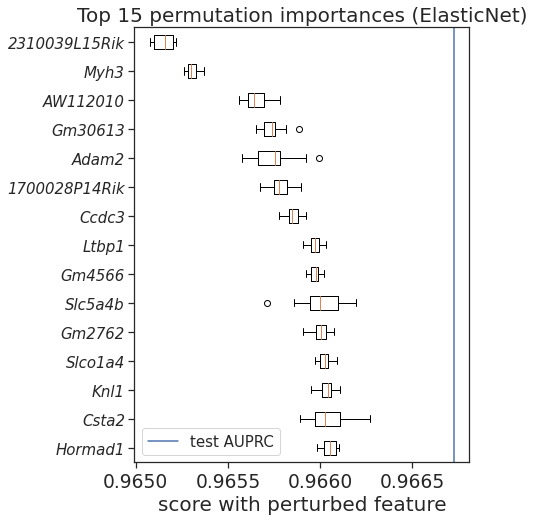

In [47]:
y_test_prob = grid.predict_proba(X_test_shuffled)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_prob)
test_score = auc(recall, precision)

sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]

top15 = sorted_indcs[-15:]

plt.figure(figsize=(6, 8))
plt.boxplot(scores[top15].T, labels=np.array(ftr_names)[top15],vert=False)
# plt.axhline(y= 15.4, color='r', label='above the line: postive features, below: negative')
plt.axvline(test_score, label='test AUPRC')
plt.title("Top 15 permutation importances (ElasticNet)", fontsize=20)
plt.xlabel('score with perturbed feature', fontsize=20)
# plt.xlim(0.95, 0.97)
plt.yticks(fontsize=15)
plt.yticks(np.arange(1, 16), np.array(ftr_names)[top15], style='italic', fontsize=15)
plt.legend(fontsize=15)
# plt.savefig('../figures/3_eln_permutation_importance_top15.pdf', bbox_inches='tight')
plt.show()